Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
## import the necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [ ]:
## If you are using the data by mounting the google drive, use the following :
##from google.colab import drive
##drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
## import the skin cancer dataset
import gdown 
url = 'https://drive.google.com/u/0/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&export=download' 
output = 'CNN_assingment.zip'
gdown.download(url, output,'quiet')

'CNN_assingment.zip'

In [ ]:
## unzip the file to a directory
!unzip CNN_assingment.zip -d CNN_assignment

Archive:  CNN_assingment.zip
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: CNN_assignment/Skin cancer ISIC Th

In [ ]:
# Defining the path for train and test images
train_path = "./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
test_path = "./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [ ]:
# display the number of train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
# define the batch size and image dimensions
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Load the train dataset from the directory with the appropriate batchsize and image resize parameters
classes  = ['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion']
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=classes, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Load the train dataset from the directory with the appropriate batchsize and image resize parameters
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=classes, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
###### visualize one instance of all the nine classes present in the dataset

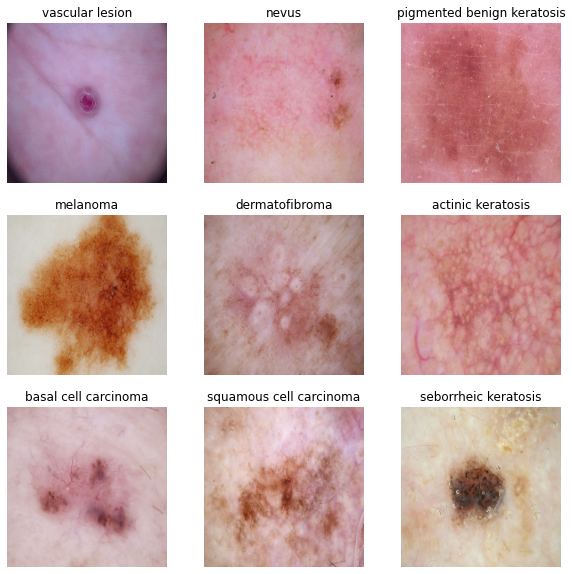

In [ ]:
## visualize one instance of all the nine classess in the dataset
plt.figure(figsize=(10, 10))
class_print=[]
j=1
class_names = train_ds.class_names
for images, labels in train_ds.take(10):
    for i in range(32):
        lbl = int(np.where(labels[i]==1)[0])
        if lbl not in class_print:
          ax = plt.subplot(3, 3, j)
          j+=1
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(class_names[lbl])
          class_print.append(lbl)
          plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# Define the model architecture
input_shape=(180,180,3)
num_classes = 9

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Comile the model with an appropirate optimiser and loss function
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
activation_38 (Activation)   (None, 180, 180, 32)      0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 178, 178, 32)      9248      
_________________________________________________________________
activation_39 (Activation)   (None, 178, 178, 32)      0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 178, 178, 32)     

### Train the model

In [ ]:
## Train the model for 20 epochs 
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 165ms/step - loss: 3.5249 - accuracy: 0.2287 - val_loss: 3.3399 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 6s 112ms/step - loss: 2.5653 - accuracy: 0.4706 - val_loss: 3.5050 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 6s 112ms/step - loss: 2.1939 - accuracy: 0.5931 - val_loss: 3.6516 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 6s 113ms/step - loss: 1.9823 - accuracy: 0.7035 - val_loss: 3.8549 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 6s 113ms/step - loss: 1.8164 - accuracy: 0.7619 - val_loss: 3.8782 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 6s 113ms/step - loss: 1.6883 - accuracy: 0.8202 - val_loss: 3.9318 - val_accuracy: 0.1633
Epoch 7/20
56/56 [==============================] - 6s 112ms/step - loss: 1.5860 - accuracy: 0.8562 - val_loss: 3.8248 - val_accuracy: 0.1678
Epoch

### Visualizing training results

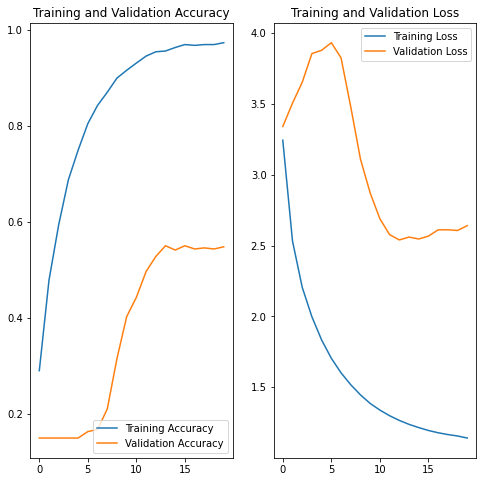

In [ ]:
## visualize the train and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation: The model is clearly overfitting as the training accuracy is much higher than the validation accuracy

### As the model is clearly overfitting we will try data augmentation to see if there is any improvement in accuracy and reduction in variance

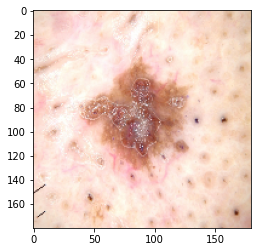

In [ ]:
# display the first image
image, label = next(iter(train_ds))
image = image[0]
_ = plt.imshow(image/255)
#_ = plt.title(get_label_name(label[0]))

In [ ]:
# define the data augmentation layer
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
## check the shape of the image
image.shape

TensorShape([180, 180, 3])

In [ ]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

In [ ]:
# check the shape of the image again
image.shape

TensorShape([1, 180, 180, 3])

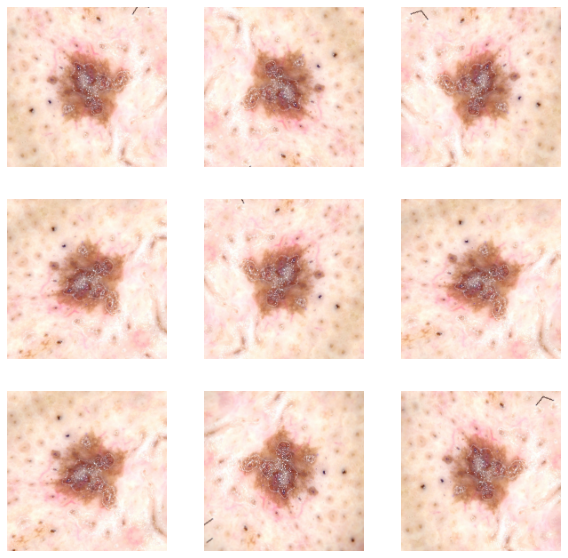

In [ ]:
## apply the data augmentation repeatedly on the first image and display it
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0]/255)
  plt.axis("off")

### Create the model, compile and train the model


In [ ]:
# define the model architecture with Dropout and Data augmentation to prevent the overfitting
input_shape=(180,180,3)
num_classes = 9

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
model.add(layers.experimental.preprocessing.RandomRotation(0.2))
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compiling the model

In [ ]:
### Compile the model with an appropirate optimiser and loss function
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
## display the model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
activation_44 (Activation)   (None, 180, 180, 32)      0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 178, 178, 32)     

### Training the model

In [ ]:
## Train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 115ms/step - loss: 3.7619 - accuracy: 0.2024 - val_loss: 3.3669 - val_accuracy: 0.0537
Epoch 2/20
56/56 [==============================] - 6s 113ms/step - loss: 3.1126 - accuracy: 0.3690 - val_loss: 3.5502 - val_accuracy: 0.0537
Epoch 3/20
56/56 [==============================] - 6s 114ms/step - loss: 2.9671 - accuracy: 0.3959 - val_loss: 3.7273 - val_accuracy: 0.0626
Epoch 4/20
56/56 [==============================] - 6s 115ms/step - loss: 2.8410 - accuracy: 0.4276 - val_loss: 3.7934 - val_accuracy: 0.1298
Epoch 5/20
56/56 [==============================] - 6s 115ms/step - loss: 2.7508 - accuracy: 0.4214 - val_loss: 3.7865 - val_accuracy: 0.1566
Epoch 6/20
56/56 [==============================] - 6s 115ms/step - loss: 2.7311 - accuracy: 0.4202 - val_loss: 3.6449 - val_accuracy: 0.1745
Epoch 7/20
56/56 [==============================] - 6s 114ms/step - loss: 2.5691 - accuracy: 0.5010 - val_loss: 3.3517 - val_accuracy: 0.2237
Epoch 

### Visualizing the results

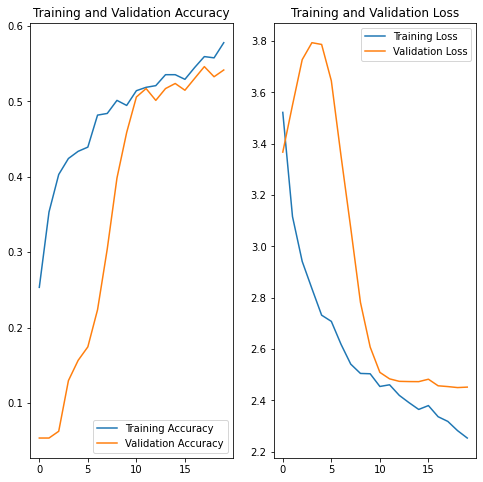

In [ ]:
## visualize the loss and accuracy for train and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation :  The model is still underfitting due to low accuracy. No improvement seen in accuracy. However the variance between the train and validation accurarices has significantly reduced which is a good sign. 

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## get the list of files in the train datasets from all sub-directories
from glob import glob
path_list_orig = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_orig

['CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000432.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0011132.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010417.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010993.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010791.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010469.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0009960.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010289.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/IS

In [ ]:
## get the sub_directory name for all the files in the train directory
lesion_list_orig = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list_orig

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [ ]:
## create a combined dictionary with the file path and sub_directory name
dataframe_dict_orig = dict(zip(path_list_orig, lesion_list_orig))
dataframe_dict_orig

{'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000432.jpg': 'melanoma',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0011132.jpg': 'melanoma',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010417.jpg': 'melanoma',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010993.jpg': 'melanoma',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010791.jpg': 'melanoma',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010469.jpg': 'melanoma',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0009960.jpg': 'melanoma',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010289.jpg': 'melanoma',


In [ ]:
## create a dataframe with the file names and sub_directory names
original_df = pd.DataFrame(list(dataframe_dict_orig.items()),columns = ['Path','Label'])

In [ ]:
## count the number of files in each sub-directory
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

##**Findings**
#### * seborrheic keratosis has the least number of samples(77)
#### * pigmented benign keratosis(462) and melanoma(438) dominate the set with the highest number of samples


#### Rectify the class imbalance
#### Use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
## create the augmentor pipeline and create the additional files
path_to_training_dataset= train_path
import Augmentor
for i in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset + i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4884140CD0>: 100%|██████████| 500/500 [00:15<00:00, 32.65 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F48840EAC50>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F48C0069CD0>: 100%|██████████| 500/500 [00:15<00:00, 31.94 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F487F6B1D50>: 100%|██████████| 500/500 [00:15<00:00, 31.56 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F487D9D6E90>: 100%|██████████| 500/500 [01:25<00:00,  5.84 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F487D974950>: 100%|██████████| 500/500 [01:21<00:00,  6.16 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F487C19AB50>:   0%|          | 1/500 [00:00<00:54,  9.23 Samples/s]

Initialised with 462 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F487C141A10>: 100%|██████████| 500/500 [00:15<00:00, 31.83 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F487D979850>: 100%|██████████| 500/500 [00:38<00:00, 12.87 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F487C067A10>: 100%|██████████| 500/500 [00:15<00:00, 31.90 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F487D974110>: 100%|██████████| 500/500 [00:15<00:00, 31.47 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
## count the augmented images in each of the sub-directory
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
## get the list of new images from the sub-directories
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010546.jpg_341f367c-d2ee-4205-9233-817fadc9c6c0.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009910.jpg_f470e40f-bdfd-4a68-9974-66745159aff4.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010396.jpg_6912f6ab-8428-4df9-b092-89e3cbd8b095.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001119.jpg_efa0eaeb-e18e-4d8b-8fe9-2faddb5743a0.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000162.jpg_8eafdeb2-4d13-49f9-8885-67ac82ad3488.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/mela

In [ ]:
## get the sub-directory name for all the new images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [ ]:
## create a dataframe with the path of the new images and the sub-directory name
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
## combine the dataframes with the old and new images list data
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df

,Path,Label
0,CNN_assignment/Skin cancer ISIC The Internatio...,melanoma
1,CNN_assignment/Skin cancer ISIC The Internatio...,melanoma
2,CNN_assignment/Skin cancer ISIC The Internatio...,melanoma
3,CNN_assignment/Skin cancer ISIC The Internatio...,melanoma
4,CNN_assignment/Skin cancer ISIC The Internatio...,melanoma
...,...,...
4495,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion
4496,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion
4497,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion
4498,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion


In [ ]:
## display the new new value counts after the new images are added
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance.

#### Train the model on the data created using Augmentor

In [ ]:
## set the batch size and image dimensions
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
## create the train dataset from the directory using the batch size and image dimension parameters. The target labels will be inferred from the sub-directory names
#data_dir_train="path to directory with training data + data created using augmentor"
classes  = ['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion']
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=classes, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [ ]:
## create the validation dataset from the directory using the batch size and image dimension parameters. The target labels will be inferred from the sub-directory names
#data_dir_train="path to directory with training data + data created using augmentor"
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=classes, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model with normalization applied on the dataset

In [ ]:
# define the model architecture as before
input_shape=(180,180,3)
num_classes = 9

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#### Compile your model using appropriate optimizer and loss function

In [ ]:
## Compile the model with an appropriate optimizer and loss function
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
## display the model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
activation_62 (Activation)   (None, 180, 180, 32)      0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 178, 178, 32)      9248      
_________________________________________________________________
activation_63 (Activation)   (None, 178, 178, 32)      0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 178, 178, 32)    

#### Train your model

In [ ]:
## train the model for 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 47s 269ms/step - loss: 4.0003 - accuracy: 0.2029 - val_loss: 3.3001 - val_accuracy: 0.1514
Epoch 2/30
169/169 [==============================] - 46s 264ms/step - loss: 2.8454 - accuracy: 0.4049 - val_loss: 3.1372 - val_accuracy: 0.2301
Epoch 3/30
169/169 [==============================] - 46s 266ms/step - loss: 2.5148 - accuracy: 0.4837 - val_loss: 2.6020 - val_accuracy: 0.4261
Epoch 4/30
169/169 [==============================] - 45s 261ms/step - loss: 2.3047 - accuracy: 0.5559 - val_loss: 2.1608 - val_accuracy: 0.6088
Epoch 5/30
169/169 [==============================] - 45s 261ms/step - loss: 2.1995 - accuracy: 0.5828 - val_loss: 2.0229 - val_accuracy: 0.6533
Epoch 6/30
169/169 [==============================] - 45s 260ms/step - loss: 2.0403 - accuracy: 0.6374 - val_loss: 1.9622 - val_accuracy: 0.6793
Epoch 7/30
169/169 [==============================] - 45s 262ms/step - loss: 1.9530 - accuracy: 0.6713 - val_loss: 1.9207 - val_ac

#### Visualize the model results

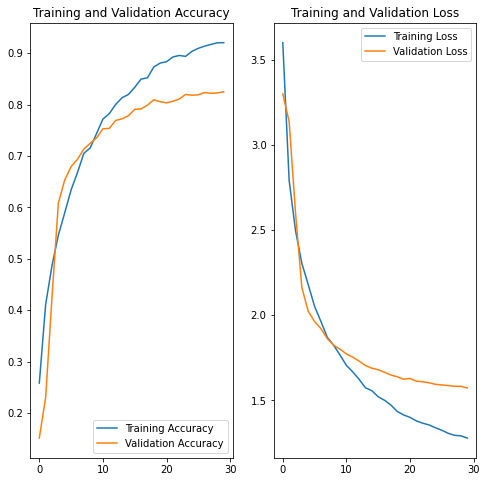

In [ ]:
## visualize the training and validation loss and accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Final Observation** The underfitting has been fixed. The accuracy of the train and validation data sets has increased signficantly.  The variance between the train and validation accuracies has also reduced significantly.  Yes, the class rebalancing has helped in a big way

